In [ ]:
#@title Copyright 2020 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# An Intro to the Earth Engine Python API

Author: guiattard

Within the last decade, a large amount of geospatial data, such as satellite data (e.g. land surface temperature, vegetation) or the output of large scale, even global models (e.g. wind speed, groundwater recharge), have become freely available from multiple national agencies and universities (e.g. NASA, USGS, NOAA, and ESA). These geospatial data are used every day by scientists and engineers of all fields, to predict weather, prevent disasters, secure water supply, or study the consequences of climate change. When using these geospatial data, a few questions arise:

- What data are available and where can it be found?
- How can we access these data?
- How can we manipulate these petabytes of data?

In this tutorial, an introduction to the [Google Earth Engine Python API](https://developers.google.com/earth-engine/guides/python_install) is presented. After some setup and some exploration of the Earth Engine Data Catalog, we’ll see how to handle geospatial datasets with [pandas](https://pandas.pydata.org/) and make some plots with matplotlib.

First, we’ll see how to get the timeseries of a variable for a region of interest. An application of this procedure will be done to extract land surface temperature in an urban and a rural area near the city of Lyon, France to illustrate the heat island effect. Secondly, we will detail procedures for static mapping and exporting results as a GeoTIFF.

Finally, the folium library will be introduced to make interactive maps. In this last part, we’ll see how to include some GEE datasets as tile layers of a folium map.

## Exploration of the Earth Engine Data Catalog

Have you ever thought that getting a meteorological dataset could be as easy as finding the nearest pizzeria? To convince you, visit the [Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/catalog) and explore datasets using the search bar or browsing by tag.

Let's say that we need to know the elevation of a region, some soil properties (e.g. clay, sand, silt content) and some meteorological observations (e.g. temperature, precipitation, evapotranspiration). Well, inside the Earth Engine Catalog we find:

- [SRTM global elevation](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003) with a resolution of 30 m,
- [OpenLandMap datasets](https://developers.google.com/earth-engine/datasets/catalog/OpenLandMap_SOL_SOL_CLAY-WFRACTION_USDA-3A1A1A_M_v02) with soil properties at a resolution of 250 m (e.g. clay, sand, and silt content), and
- [GRIDMET](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET) temperature, precipitation, and evapotranspiration, for example.

Of course the resolution, frequency, spatial and temporal extent, as well as data source (e.g. satellite image, interpolated station data, or model output) vary from one dataset to another. Therefore, read the description carefully and make sure you know what kind of dataset you are selecting!


## Run me first

First of all, run the following cell to initialize the API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

In [2]:
# Install necessary packages if not already installed
!pip install earthengine-api
!pip install geemap

# Import libraries
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os

# Authenticate and initialize Earth Engine
try:
    ee.Initialize(project='eee-666')
except Exception:
    # If not authenticated, run this
    ee.Authenticate()
    ee.Initialize()

In [30]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [33]:
city_df

,city,lat,lon
0,Bangkok,13.75,100.51
1,Beijing,39.91,116.39
2,Busan,35.19,129.10
3,Chengdu,30.65,104.07
4,Chongqing,29.56,106.57
5,Delhi,28.65,77.23
6,Dhaka,23.71,90.41
7,Hangzhou,30.29,120.16
8,Hanoi,21.03,105.83
9,Hefei,31.86,117.28


Collection information:
[{'id': 'ACET', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'ALD2', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'ALK4', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'BCPI', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'BCPO', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'BENZ', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [14

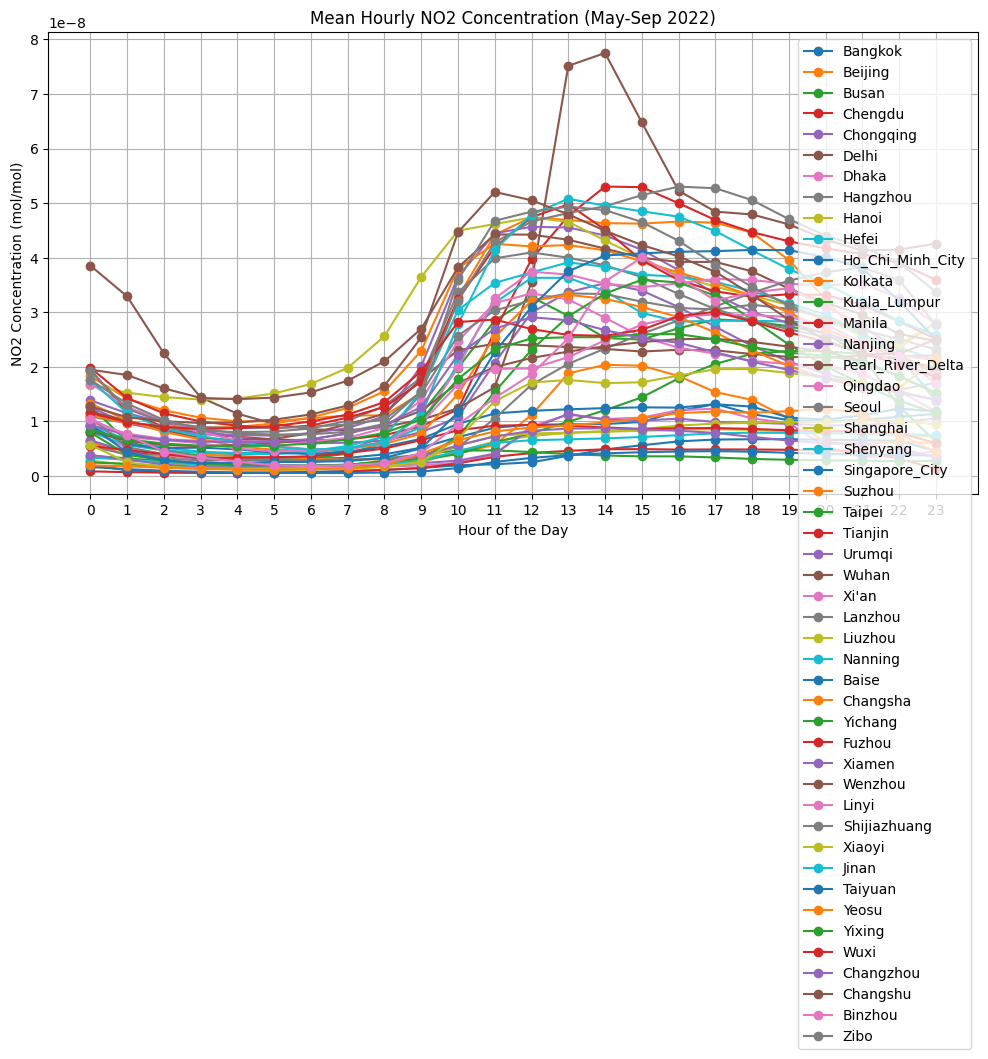

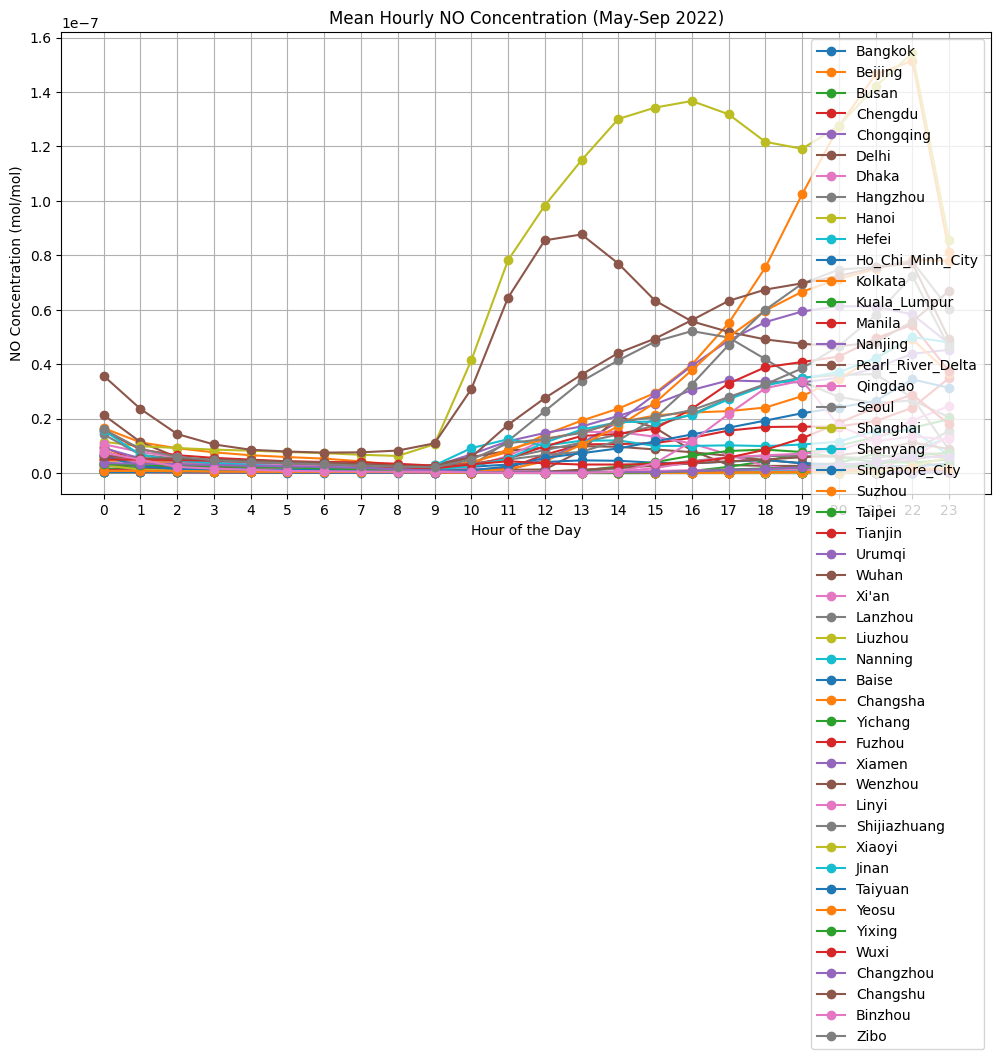

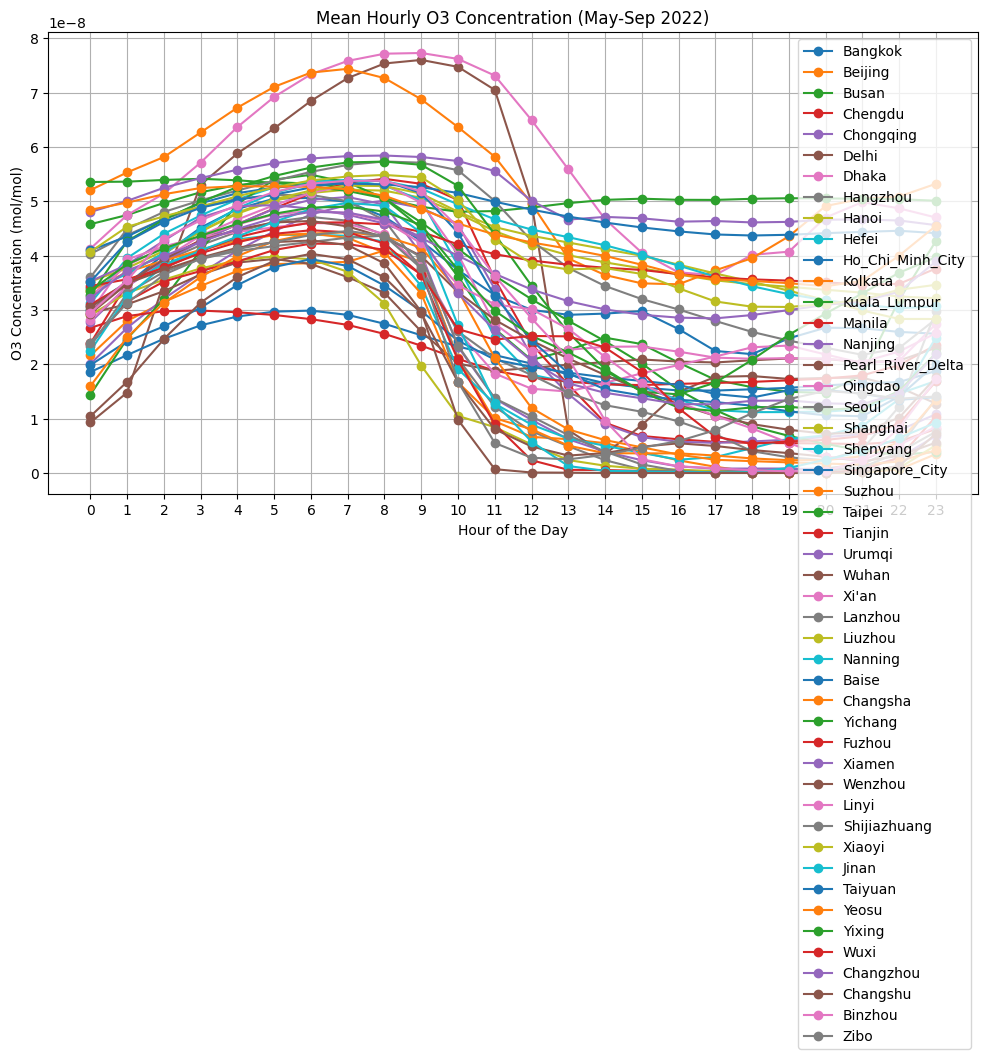

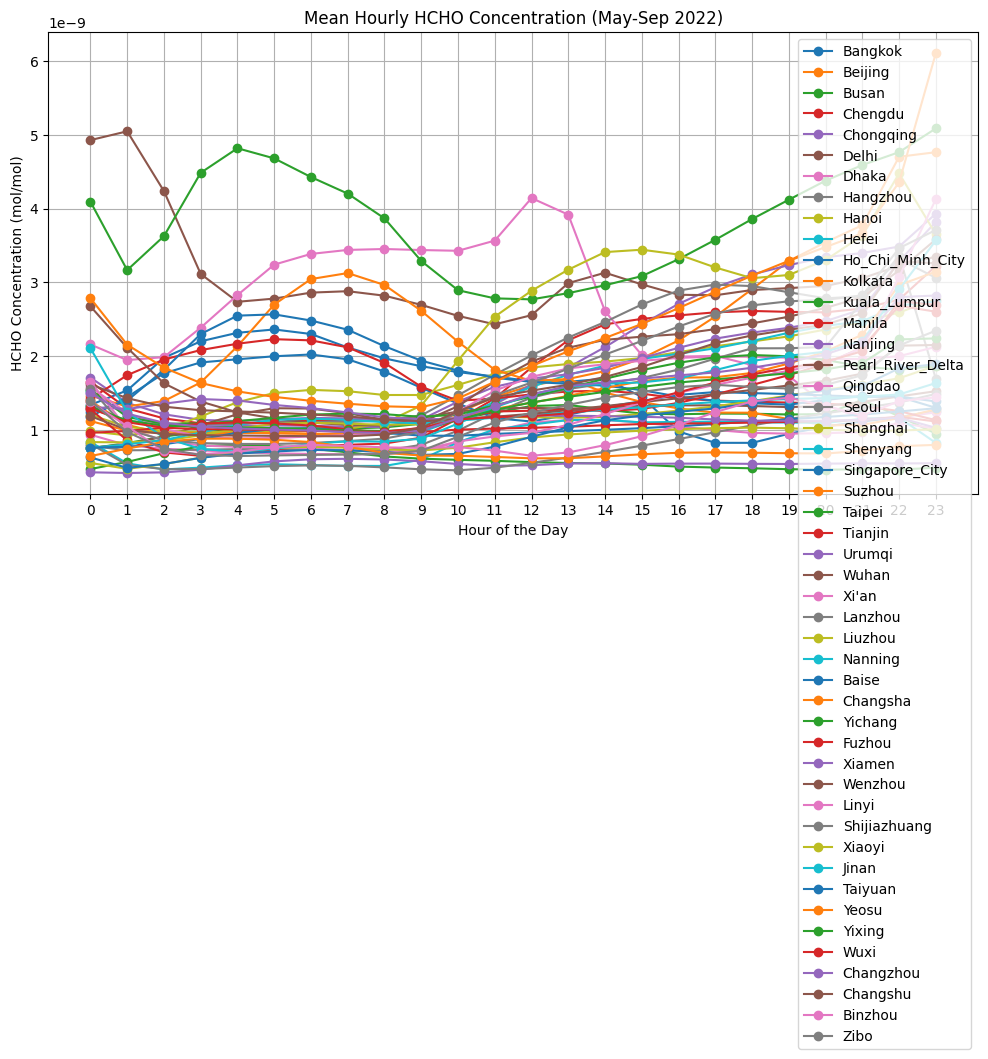

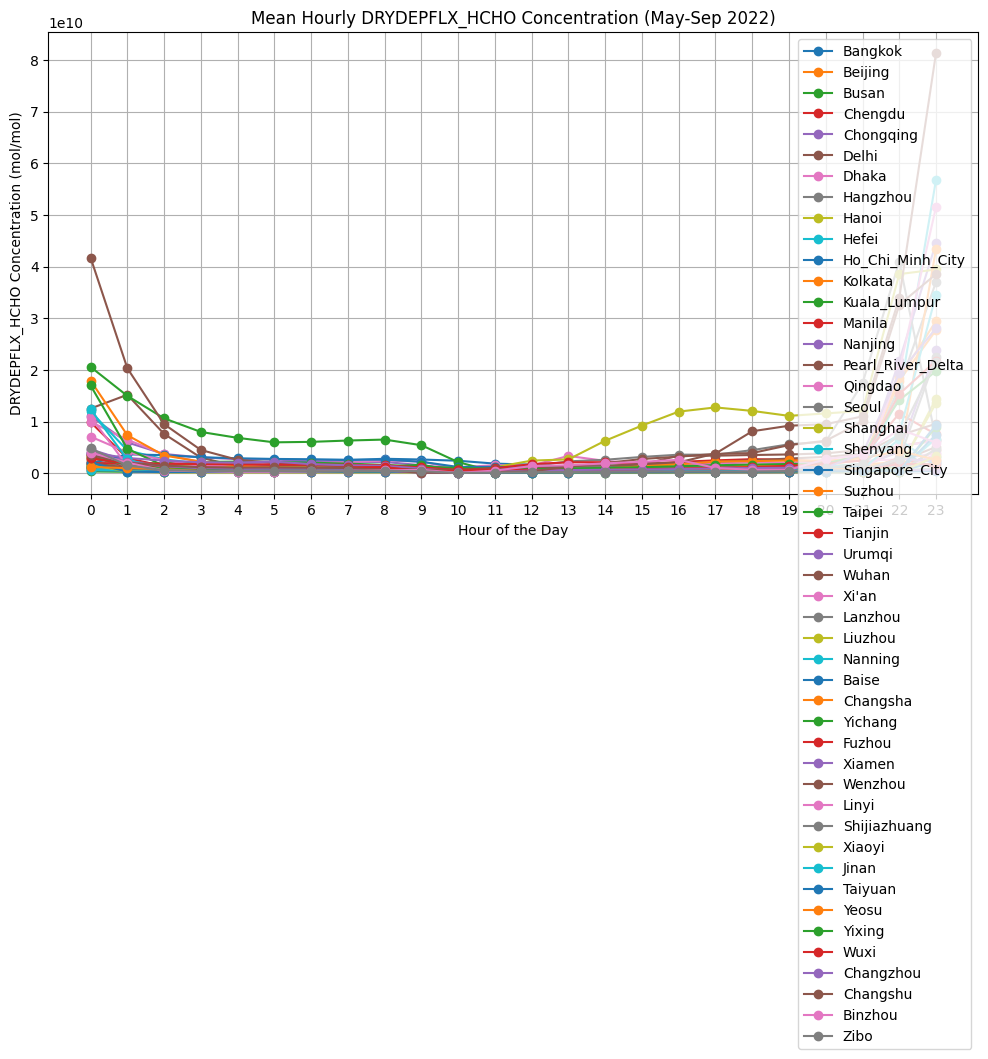

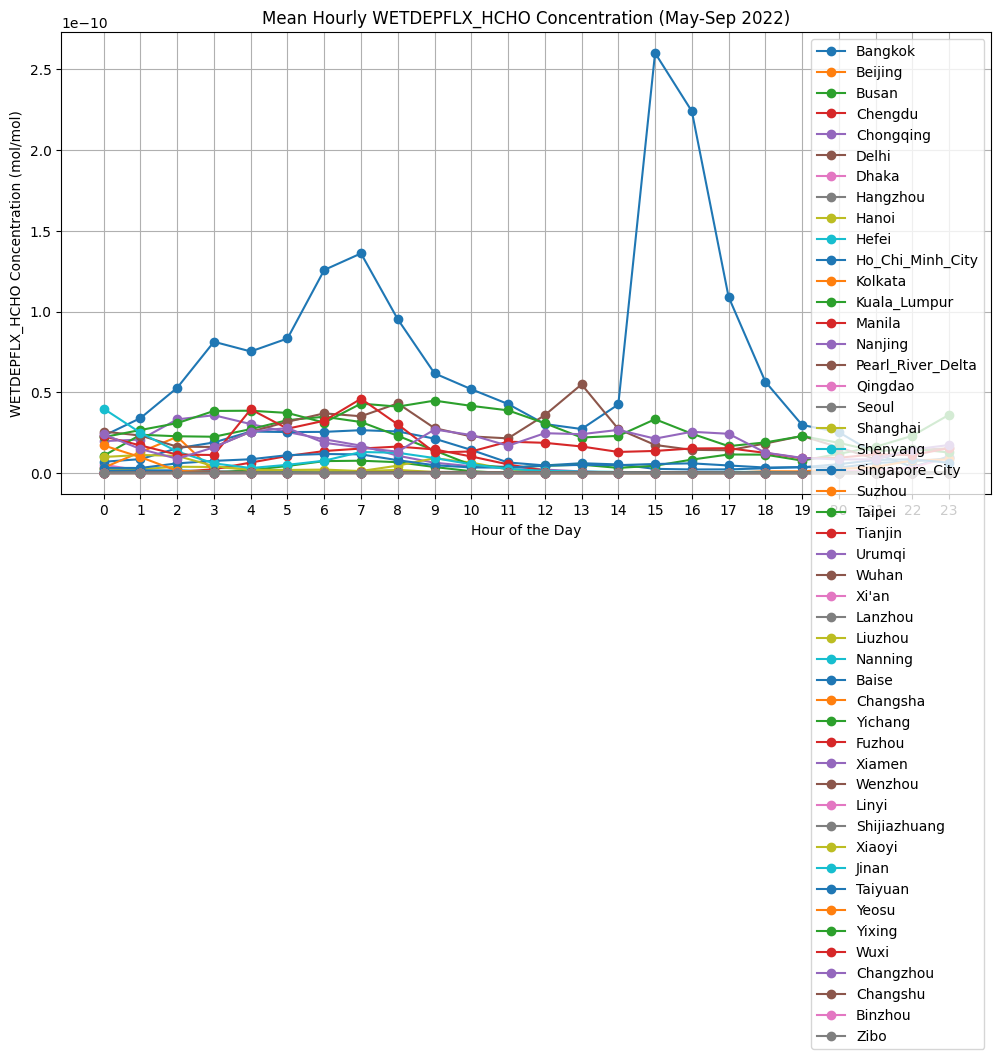

In [34]:
# Define time range for data extraction
start_date = '2022-05-01'
end_date = '2022-05-03'

# Load the NASA GEOS-CF dataset
geos_cf = ee.ImageCollection("NASA/GEOS-CF/v1/rpl/tavg1hr") \
    .filterDate(start_date, end_date)

# Print collection metadata to understand available bands
print("Collection information:")
print(geos_cf.getInfo()['features'][0]['bands'])

# Select required bands
bands = ['NO2', 'NO', 'O3', 'HCHO', 'DRYDEPFLX_HCHO', 'WETDEPFLX_HCHO']
data_collection = geos_cf.select(bands)

# Load city coordinates from CSV
city_df = pd.read_csv('/content/drive/MyDrive/AsiaCity2025.csv')

# Function to extract hourly values for multiple gases
def extract_hourly_data(city_name, lat, lon, date_str):
    date = ee.Date(date_str)
    next_date = date.advance(1, 'day')
    hourly_data = data_collection.filterDate(date, next_date)

    if hourly_data.size().getInfo() == 0:
        print(f"No data available for {city_name} on {date_str}")
        return []

    roi = ee.Geometry.Point(lon, lat).buffer(10000)  # 10km buffer
    results = []
    images = hourly_data.toList(hourly_data.size())

    for i in range(hourly_data.size().getInfo()):
        img = ee.Image(images.get(i))
        try:
            result = img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=roi,
                scale=27750,
                maxPixels=1e9
            ).getInfo()

            date_time_str = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd HH').getInfo()
            results.append({
                'city': city_name,
                'date': datetime.strptime(date_time_str, '%Y-%m-%d %H'),
                **{band: result.get(band, None) for band in bands}
            })
        except Exception as e:
            print(f"Error processing hour {i} on {date_str} for {city_name}: {e}")
            results.append({'city': city_name, 'date': None})

    return results

# Generate date range
start = datetime.strptime(start_date, '%Y-%m-%d')
end = datetime.strptime(end_date, '%Y-%m-%d')
date_list = [(start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range((end - start).days + 1)]

# Extract data for all cities
data = []
for _, row in city_df.iterrows():
    city_name, lat, lon = row['city'], row['lat'], row['lon']
    for date_str in date_list:
        data.extend(extract_hourly_data(city_name, lat, lon, date_str))

# Convert to DataFrame
data_df = pd.DataFrame(data)

# Convert date to datetime format
data_df = data_df.dropna(subset=['date'])
data_df['hour'] = data_df['date'].dt.hour

# Plot results for each gas
for band in bands:
    plt.figure(figsize=(12, 6))
    for city in data_df['city'].unique():
        city_data = data_df[data_df['city'] == city]
        mean_hourly_data = city_data.groupby('hour')[band].mean()
        plt.plot(mean_hourly_data.index, mean_hourly_data, marker='o', label=city)

    plt.title(f'Mean Hourly {band} Concentration (May-Sep 2022)')
    plt.xlabel('Hour of the Day')
    plt.ylabel(f'{band} Concentration (mol/mol)')
    plt.grid(True)
    plt.xticks(range(24))
    plt.legend()
    plt.show()


In [35]:
data_df

,city,date,NO2,NO,O3,HCHO,DRYDEPFLX_HCHO,WETDEPFLX_HCHO,hour
0,Bangkok,2022-05-01 00:00:00,3.935494e-09,8.481831e-10,3.259469e-08,1.576780e-09,6.612231e+09,7.915968e-12,0
1,Bangkok,2022-05-01 01:00:00,2.663503e-09,8.200722e-10,3.774633e-08,2.019474e-09,3.197106e+09,1.021865e-11,1
2,Bangkok,2022-05-01 02:00:00,2.346164e-09,6.887795e-10,4.509438e-08,2.731191e-09,1.831263e+09,2.059036e-11,2
3,Bangkok,2022-05-01 03:00:00,2.070579e-09,4.869051e-10,5.156611e-08,2.929372e-09,1.623106e+09,5.330452e-11,3
4,Bangkok,2022-05-01 04:00:00,2.172276e-09,4.370706e-10,5.548258e-08,2.966556e-09,1.668478e+09,5.324872e-11,4
...,...,...,...,...,...,...,...,...,...
2299,Zibo,2022-05-02 19:00:00,2.075985e-08,2.823671e-10,2.721671e-08,1.004964e-09,3.628680e+08,0.000000e+00,19
2300,Zibo,2022-05-02 20:00:00,1.819475e-08,8.406969e-11,3.024594e-08,9.473366e-10,1.329452e+09,0.000000e+00,20
2301,Zibo,2022-05-02 21:00:00,1.764684e-08,5.864587e-10,2.897220e-08,9.681113e-10,3.104384e+09,0.000000e+00,21
2302,Zibo,2022-05-02 22:00:00,1.700039e-08,3.442961e-09,2.625937e-08,1.108252e-09,6.977693e+09,0.000000e+00,22


Collection information:
[{'id': 'ACET', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'ALD2', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'ALK4', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'BCPI', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'BCPO', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'BENZ', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [14

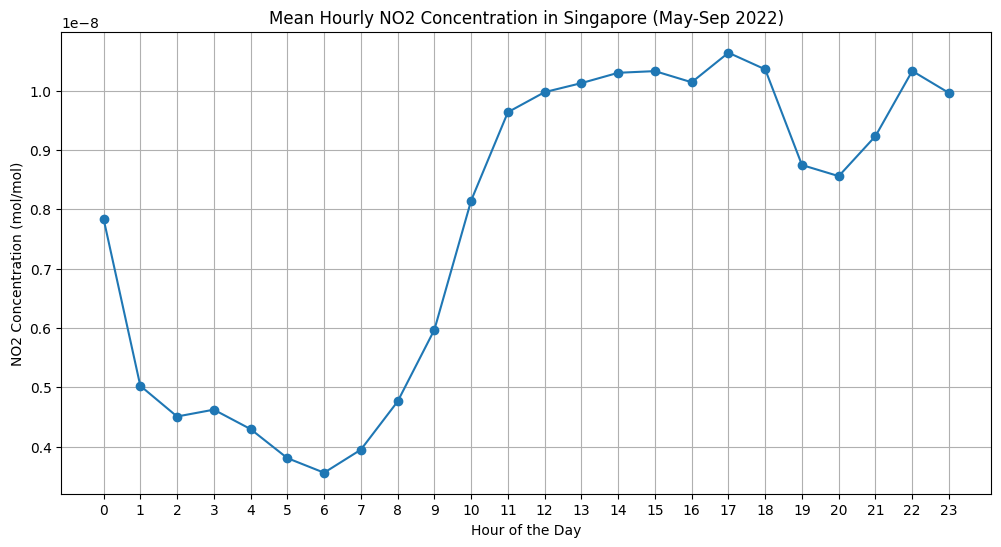

In [28]:


# Define time range for data extraction
start_date = '2022-05-01'
end_date = '2022-05-03'

# Load the NASA GEOS-CF dataset
geos_cf = ee.ImageCollection("NASA/GEOS-CF/v1/rpl/tavg1hr") \
    .filterDate(start_date, end_date)

# Print collection metadata to understand available bands
print("Collection information:")
print(geos_cf.getInfo()['features'][0]['bands'])

# Select NO2 data
no2_collection = geos_cf.select('NO2')

# Define Singapore region (ROI)
singapore_lat = 1.3521
singapore_lon = 103.8198
point = ee.Geometry.Point(singapore_lon, singapore_lat)
roi = point.buffer(10000)  # 10km buffer

# Function to extract hourly NO2 values

def extract_hourly_no2(date_str):
    date = ee.Date(date_str)
    next_date = date.advance(1, 'day')
    hourly_no2 = no2_collection.filterDate(date, next_date)

    if hourly_no2.size().getInfo() == 0:
        print(f"No data available for {date_str}")
        return []

    results = []
    images = hourly_no2.toList(hourly_no2.size())
    for i in range(hourly_no2.size().getInfo()):
        img = ee.Image(images.get(i))
        try:
            result = img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=roi,
                scale=27750,
                maxPixels=1e9
            ).getInfo()
            mean_no2 = result.get('NO2', None)
            # Convert Earth Engine date to string and then to Python datetime
            date_time_str = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd HH').getInfo()
            results.append({'date': datetime.strptime(date_time_str, '%Y-%m-%d %H'), 'NO2': mean_no2})
        except Exception as e:
            print(f"Error processing hour {i} on {date_str}: {e}")
            results.append({'date': None, 'NO2': None})

    return results

# Generate date range
start = datetime.strptime(start_date, '%Y-%m-%d')
end = datetime.strptime(end_date, '%Y-%m-%d')
date_list = [(start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range((end - start).days + 1)]

# Extract NO2 values
no2_data = []
for date_str in date_list:
    no2_data.extend(extract_hourly_no2(date_str))

# Convert to DataFrame
no2_df = pd.DataFrame(no2_data)

# Convert date to datetime format
no2_df = no2_df.dropna(subset=['date'])
no2_df['hour'] = no2_df['date'].dt.hour

# Calculate the mean NO2 by hour
mean_hourly_no2 = no2_df.groupby('hour')['NO2'].mean()

# Plot results
plt.figure(figsize=(12, 6))
mean_hourly_no2.plot(marker='o')
plt.title('Mean Hourly NO2 Concentration in Singapore (May-Sep 2022)')
plt.xlabel('Hour of the Day')
plt.ylabel('NO2 Concentration (mol/mol)')
plt.grid(True)
plt.xticks(range(24))
plt.show()


In [ ]:


# Define time range for data extraction
start_date = '2022-05-01'
end_date = '2022-05-03'

# Load the NASA GEOS-CF dataset
geos_cf = ee.ImageCollection("NASA/GEOS-CF/v1/rpl/tavg1hr") \
    .filterDate(start_date, end_date)

# Print collection metadata to understand available bands
print("Collection information:")
print(geos_cf.getInfo()['features'][0]['bands'])

# Select NO2 data
no2_collection = geos_cf.select('NO2')

# Define Singapore region (ROI)
singapore_lat = 1.3521
singapore_lon = 103.8198
point = ee.Geometry.Point(singapore_lon, singapore_lat)
roi = point.buffer(10000)  # 10km buffer

# Function to extract hourly NO2 values

def extract_hourly_no2(date_str):
    date = ee.Date(date_str)
    next_date = date.advance(1, 'day')
    hourly_no2 = no2_collection.filterDate(date, next_date)

    if hourly_no2.size().getInfo() == 0:
        print(f"No data available for {date_str}")
        return []

    results = []
    images = hourly_no2.toList(hourly_no2.size())
    for i in range(hourly_no2.size().getInfo()):
        img = ee.Image(images.get(i))
        try:
            result = img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=roi,
                scale=27750,
                maxPixels=1e9
            ).getInfo()
            mean_no2 = result.get('NO2', None)
            results.append({'date': date.advance(i, 'hour').format('YYYY-MM-dd HH'), 'NO2': mean_no2})
        except Exception as e:
            print(f"Error processing hour {i} on {date_str}: {e}")
            results.append({'date': date.advance(i, 'hour').format('YYYY-MM-dd HH'), 'NO2': None})

    return results

# Generate date range
start = datetime.strptime(start_date, '%Y-%m-%d')
end = datetime.strptime(end_date, '%Y-%m-%d')
date_list = [(start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range((end - start).days + 1)]

# Extract NO2 values
no2_data = []
for date_str in date_list:
    no2_data.extend(extract_hourly_no2(date_str))

# Convert to DataFrame
no2_df = pd.DataFrame(no2_data)

# Convert date to datetime format
no2_df['date'] = pd.to_datetime(no2_df['date'])
no2_df['hour'] = no2_df['date'].dt.hour

# Calculate the mean NO2 by hour
mean_hourly_no2 = no2_df.groupby('hour')['NO2'].mean()

# Plot results
plt.figure(figsize=(12, 6))
mean_hourly_no2.plot(marker='o')
plt.title('Mean Hourly NO2 Concentration in Singapore (May-Sep 2022)')
plt.xlabel('Hour of the Day')
plt.ylabel('NO2 Concentration (mol/mol)')
plt.grid(True)
plt.xticks(range(24))
plt.show()


In [11]:


# Define time range for data extraction
start_date = '2022-05-01'
end_date = '2022-09-30'

# Load the NASA GEOS-CF dataset
geos_cf = ee.ImageCollection("NASA/GEOS-CF/v1/rpl/tavg1hr") \
    .filterDate(start_date, end_date)

# Print collection metadata to understand available bands
print("Collection information:")
print(geos_cf.getInfo()['features'][0]['bands'])

# Select NO2 data
no2_collection = geos_cf.select('NO2')

# Define Singapore region (ROI)
singapore_lat = 1.3521
singapore_lon = 103.8198
point = ee.Geometry.Point(singapore_lon, singapore_lat)
roi = point.buffer(10000)  # 10km buffer

# Function to extract hourly NO2 values

def extract_hourly_no2(date_str):
    date = ee.Date(date_str)
    next_date = date.advance(1, 'day')
    hourly_no2 = no2_collection.filterDate(date, next_date)

    if hourly_no2.size().getInfo() == 0:
        print(f"No data available for {date_str}")
        return []

    results = []
    images = hourly_no2.toList(hourly_no2.size())
    for i in range(hourly_no2.size().getInfo()):
        img = ee.Image(images.get(i))
        try:
            result = img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=roi,
                scale=27750,
                maxPixels=1e9
            ).getInfo()
            mean_no2 = result.get('NO2', None)
            results.append({'date': date.advance(i, 'hour').format('YYYY-MM-dd HH'), 'NO2': mean_no2})
        except Exception as e:
            print(f"Error processing hour {i} on {date_str}: {e}")
            results.append({'date': date.advance(i, 'hour').format('YYYY-MM-dd HH'), 'NO2': None})

    return results

# Generate date range
start = datetime.strptime(start_date, '%Y-%m-%d')
end = datetime.strptime(end_date, '%Y-%m-%d')
date_list = [(start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range((end - start).days + 1)]

# Extract NO2 values
no2_data = []
for date_str in date_list:
    no2_data.extend(extract_hourly_no2(date_str))

# Convert to DataFrame
no2_df = pd.DataFrame(no2_data)

# Convert date to datetime format
no2_df['date'] = pd.to_datetime(no2_df['date'])
no2_df['hour'] = no2_df['date'].dt.hour

# Calculate the mean NO2 by hour
mean_hourly_no2 = no2_df.groupby('hour')['NO2'].mean()

# Plot results
plt.figure(figsize=(12, 6))
mean_hourly_no2.plot(marker='o')
plt.title('Mean Hourly NO2 Concentration in Singapore (May-Sep 2022)')
plt.xlabel('Hour of the Day')
plt.ylabel('NO2 Concentration (mol/mol)')
plt.grid(True)
plt.xticks(range(24))
plt.show()


Collection information:
[{'id': 'ACET', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'ALD2', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'ALK4', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'BCPI', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'BCPO', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'BENZ', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [14

TypeError: <class 'ee.ee_string.String'> is not convertible to datetime, at position 0

In [24]:
no2_df

,date,NO2
0,"ee.String({\n ""functionInvocationValue"": {\n ...",8.480096e-09
1,"ee.String({\n ""functionInvocationValue"": {\n ...",5.613507e-09
2,"ee.String({\n ""functionInvocationValue"": {\n ...",4.903893e-09
3,"ee.String({\n ""functionInvocationValue"": {\n ...",4.996437e-09
4,"ee.String({\n ""functionInvocationValue"": {\n ...",4.676433e-09
...,...,...
3643,"ee.String({\n ""functionInvocationValue"": {\n ...",1.056483e-08
3644,"ee.String({\n ""functionInvocationValue"": {\n ...",1.086162e-08
3645,"ee.String({\n ""functionInvocationValue"": {\n ...",1.100451e-08
3646,"ee.String({\n ""functionInvocationValue"": {\n ...",1.111115e-08


In [25]:
no2_df.describe()

,NO2
count,3.648000e+03
mean,8.071927e-09
std,3.625787e-09
min,1.889116e-09
25%,4.915299e-09
50%,7.894977e-09
75%,1.072486e-08
max,2.166822e-08


In [21]:
str(no2_df.iloc[0]['date'])

'ee.String({\n  "functionInvocationValue": {\n    "functionName": "Date.format",\n    "arguments": {\n      "date": {\n        "functionInvocationValue": {\n          "functionName": "Date.advance",\n          "arguments": {\n            "date": {\n              "functionInvocationValue": {\n                "functionName": "Date",\n                "arguments": {\n                  "value": {\n                    "constantValue": "2022-05-01"\n                  }\n                }\n              }\n            },\n            "delta": {\n              "constantValue": 0\n            },\n            "unit": {\n              "constantValue": "hour"\n            }\n          }\n        }\n      },\n      "format": {\n        "constantValue": "YYYY-MM-dd HH"\n      }\n    }\n  }\n})'

Collection information:
[{'id': 'ACET', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'ALD2', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'ALK4', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'BCPI', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'BCPO', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 721], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0, -180.125, 0, -0.25, 90.125]}, {'id': 'BENZ', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [14

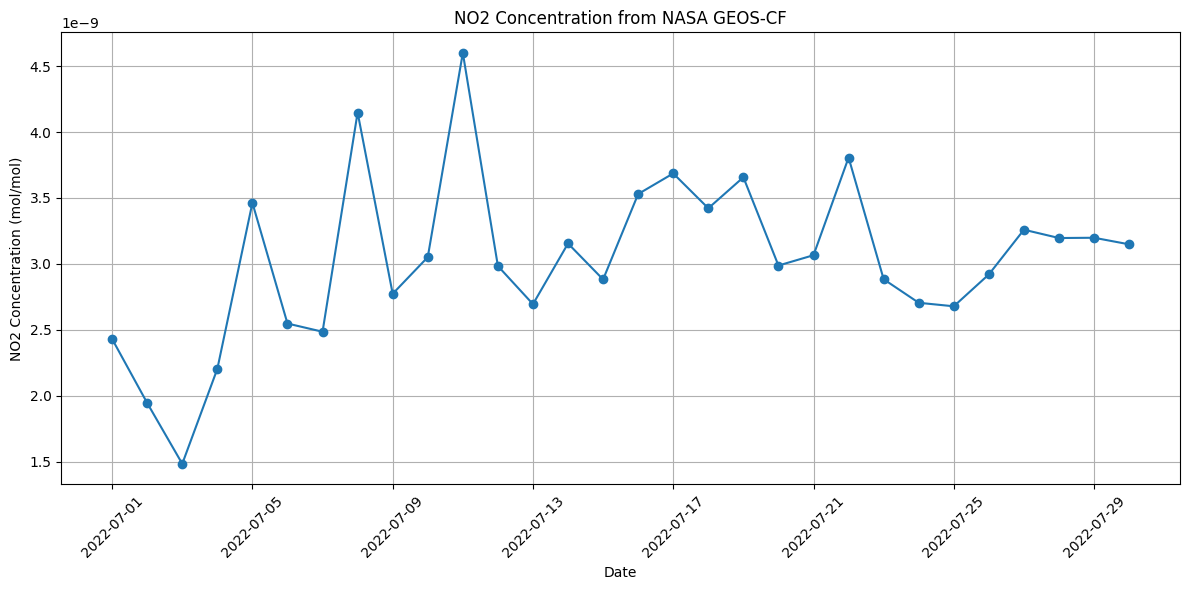

Map(center=[37.77491025887284, -122.41939964007518], controls=(WidgetControl(options=['position', 'transparent…

In [26]:
# Define time range for data extraction
start_date = '2022-07-01'
end_date = '2022-07-31'  # You can adjust the date range as needed

# Load the NASA GEOS-CF dataset
geos_cf = ee.ImageCollection("NASA/GEOS-CF/v1/rpl/tavg1hr") \
    .filterDate(start_date, end_date)

# Print collection metadata to understand available bands
print("Collection information:")
print(geos_cf.getInfo()['features'][0]['bands'])

# Filter the collection to get NO2 data
# The specific band for NO2 in GEOS-CF is 'NO2'
no2_collection = geos_cf.select('NO2')

# Define a region of interest (ROI) - example for a point location
# Change these coordinates to your area of interest
lat = 37.7749
lon = -122.4194  # Example: San Francisco
point = ee.Geometry.Point(lon, lat)
roi = point.buffer(10000)  # 10km buffer

# Function to extract values for a specific date
def extract_no2_for_date(date_str):
    date = ee.Date(date_str)
    next_date = date.advance(1, 'day')

    # Filter collection for the specific date
    daily_no2 = no2_collection.filterDate(date, next_date)

    # Check if we have any images for this date
    count = daily_no2.size().getInfo()
    if count == 0:
        print(f"No data available for {date_str}")
        return ee.Feature(None, {'date': date_str, 'NO2': None})

    # Get mean NO2 value for the region
    mean_img = daily_no2.mean()

    try:
        # Try computing the regional mean safely
        result = mean_img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=27750,  # Match the pixel size from the error message
            maxPixels=1e9
        ).getInfo()

        print(f"Data for {date_str}: {result}")

        # Safely get the NO2 value
        mean_no2 = result.get('NO2', None)

        return ee.Feature(None, {'date': date_str, 'NO2': mean_no2})
    except Exception as e:
        print(f"Error processing {date_str}: {e}")
        return ee.Feature(None, {'date': date_str, 'NO2': None})

# Generate a list of dates for the entire period
start = datetime.strptime(start_date, '%Y-%m-%d')
end = datetime.strptime(end_date, '%Y-%m-%d')
date_list = [(start + timedelta(days=x)).strftime('%Y-%m-%d')
             for x in range((end - start).days + 1)]

# Extract NO2 values for each date
features = []
for date_str in date_list:
    features.append(extract_no2_for_date(date_str))

# Create a feature collection with results
no2_fc = ee.FeatureCollection(features)

# Print the first feature to see its structure
print("Checking the first feature structure:")
first_feature = no2_fc.first().getInfo()
print(first_feature)

# Export to drive as CSV (optional)
task = ee.batch.Export.table.toDrive(
    collection=no2_fc,
    description='NO2_GEOS_CF_Data',
    fileFormat='CSV'
)
task.start()
print("Export task started. Check your Google Drive for results.")

# Alternative: Get the data directly for visualization using getInfo()
# This is more suitable for smaller datasets/regions
no2_fc_data = no2_fc.getInfo()

# Convert the Earth Engine Feature Collection to pandas DataFrame with safer property access
no2_data = pd.DataFrame([
    {
        'date': feature['properties'].get('date'),
        'NO2': feature['properties'].get('NO2', None)  # Use .get() with a default of None
    }
    for feature in no2_fc_data.get('features', [])
])

# Plot the results
plt.figure(figsize=(12, 6))
# Convert to datetime and handle potential None values
no2_data['date'] = pd.to_datetime(no2_data['date'])
# Convert NO2 values to numeric, coercing errors to NaN
no2_data['NO2'] = pd.to_numeric(no2_data['NO2'], errors='coerce')
# Plot only non-NaN values
valid_data = no2_data.dropna(subset=['NO2'])
plt.plot(valid_data['date'], valid_data['NO2'], marker='o')
plt.title('NO2 Concentration from NASA GEOS-CF')
plt.xlabel('Date')
plt.ylabel('NO2 Concentration (mol/mol)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Create a map visualization
Map = geemap.Map()
Map.centerObject(roi, 10)

# Calculate mean NO2 for the entire period
mean_no2_img = no2_collection.mean()

# Define visualization parameters for NO2
vis_params = {
    'min': 0,
    'max': 1e-8,  # Adjust based on your data range
    'palette': ['blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

# Add the layer to the map
Map.addLayer(mean_no2_img, vis_params, 'Mean NO2')
Map.addLayer(roi, {'color': 'black'}, 'ROI')

# Display the map
Map

In [8]:
# Define a single date for testing
test_date = '2022-01-01'

# Load the NASA GEOS-CF dataset for just that date
geos_cf = ee.ImageCollection("NASA/GEOS-CF/v1/rpl/tavg1hr") \
    .filterDate(test_date, '2022-01-02')

# Print detailed metadata
print("Collection size:", geos_cf.size().getInfo())

if geos_cf.size().getInfo() > 0:
    # Get the first image
    first_img = geos_cf.first()

    # Print image details
    print("\nImage ID:", first_img.id().getInfo())
    print("\nImage bands:", first_img.bandNames().getInfo())

    # Print metadata for each band
    for band in first_img.bandNames().getInfo():
        print(f"\nBand: {band}")
        band_info = first_img.select(band).getInfo()['bands'][0]
        for key, value in band_info.items():
            if key not in ['dimensions', 'crs', 'crs_transform']:
                print(f"  {key}: {value}")

    # Try to extract a value for a single point
    point = ee.Geometry.Point(-122.4194, 37.7749)  # San Francisco
    sample = first_img.select('NO2').sample(
        region=point,
        scale=30000,
        numPixels=1
    ).first().getInfo()

    print("\nSample at point:", sample)
else:
    print("No images found for the specified date.")

# Try a different approach - get average NO2 for each hour
if geos_cf.size().getInfo() > 0:
    # Get list of image dates/times
    image_info = geos_cf.getInfo()['features']

    print("\nAvailable images:")
    for img in image_info:
        img_id = img['id']
        img_time = img['properties'].get('system:time_start')
        if img_time:
            date_str = datetime.fromtimestamp(img_time/1000).strftime('%Y-%m-%d %H:%M:%S')
            print(f"Image ID: {img_id}, Time: {date_str}")

Collection size: 24

Image ID: 20220101_0030z

Image bands: ['ACET', 'ALD2', 'ALK4', 'BCPI', 'BCPO', 'BENZ', 'C2H6', 'C3H8', 'CH4', 'CO', 'DST1', 'DST2', 'DST3', 'DST4', 'EOH', 'H2O2', 'HCHO', 'HNO3', 'HNO4', 'ISOP', 'MACR', 'MEK', 'MVK', 'N2O5', 'NH3', 'NH4', 'NIT', 'NO', 'NO2', 'NOy', 'O3', 'OCPI', 'OCPO', 'PAN', 'PM25_RH35_GCC', 'PM25_RH35_GOCART', 'PM25bc_RH35_GCC', 'PM25du_RH35_GCC', 'PM25ni_RH35_GCC', 'PM25oc_RH35_GCC', 'PM25soa_RH35_GCC', 'PM25ss_RH35_GCC', 'PM25su_RH35_GCC', 'PRPE', 'RCHO', 'SALA', 'SALC', 'SO2', 'SOAP', 'SOAS', 'TOLU', 'XYLE', 'CLDTT', 'PHIS', 'PS', 'Q', 'Q10M', 'Q2M', 'RH', 'SLP', 'T', 'T10M', 'T2M', 'TPREC', 'TROPPB', 'TS', 'U', 'U10M', 'U2M', 'V', 'V10M', 'V2M', 'ZL', 'ZPBL', 'AOD550_BC', 'AOD550_CLOUD', 'AOD550_DST1', 'AOD550_DST2', 'AOD550_DST3', 'AOD550_DST4', 'AOD550_DST5', 'AOD550_DST6', 'AOD550_DST7', 'AOD550_DUST', 'AOD550_OC', 'AOD550_SALA', 'AOD550_SALC', 'AOD550_SULFATE', 'DRYDEPFLX_BCPI', 'DRYDEPFLX_BCPO', 'DRYDEPFLX_DST1', 'DRYDEPFLX_DST2', 'DRY

## Getting started with Collections

In the Earth Engine Data Catalog, datasets can be of different types:

- *Features* which are geometric objects with a list of properties. For example, a watershed with some properties such as *name* and *area*, is an `ee.Feature`.
- *Images* which are like features, but may include several bands. For example, the ground elevation given by the USGS [here](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003) is an `ee.Image`.
- *Collections* which are groups of features or images. For example, the [Global Administrative Unit Layers](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level0) giving administrative boundaries is a `ee.FeatureCollection` and the [MODIS Land Surface Temperature](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1) dataset is an `ee.ImageCollection`.

If you want to know more about different data models, you may want to visit the [Earth Engine User Guide](https://developers.google.com/earth-engine).

In the following sections, we work with the MODIS [land cover (LC)](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD12Q1), the MODIS [land surface temperature (LST)](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1) and with the USGS [ground elevation (ELV)](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003), which are `ee.ImageCollections`. The dataset descriptions provide us with all the information we need to import and manipulate these datasets: the availability, the provider, the Earth Engine Snippet, and the available bands associated with images in the collection.

Now, to import the LC, LST and ELV collections, we can copy and paste the Earth Engine Snippets:

In [ ]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

All of these images come in a different resolution, frequency, and possibly projection, ranging from daily images in a 1 km resolution for LST (hence an `ee.ImageCollection` — a collection of several `ee.Images`) to a single image representing data for the year 2000 in a 30 m resolution for the ELV. While we need to have an eye on the frequency, GEE takes care of resolution and projection by resampling and reprojecting all data we are going to work with to a common projection (learn more about [projections in Earth Engine](https://developers.google.com/earth-engine/guides/projections)). We can define the resolution (called scale in GEE) whenever necessary and of course have the option to force no reprojection.

As you can see in the description of the datasets, they include several sets of information stored in several bands. For example, these bands are associated with the LST collection:

- _LST\_Day\_1km_: Daytime Land Surface Temperature
- _Day\_view\_time_: Local time of day observation
- _LST\_Night\_1km_: Nighttime Land Surface Temperature
- etc.

The description page of the collection tells us that the name of the band associated with the daytime LST is _LST\_Day\_1km_ which is in units of Kelvin. In addition, values are ranging from 7,500 to 65,535 with a corrective scale of 0.02.

Then, we have to filter the collection on the period of time we want. We can do that using the `filterDate()` method. We also need to select the bands we want to work with. Therefore, we decide to focus on daytime LST so we select the daytime band _LST\_Day\_1km_ and its associated quality indicator _QC\_Day_ with the `select()` method.

In [ ]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

Now, we can either upload existing shape files or define some points with longitude and latitude coordinates where we want to know more about LC, LST and ELV. For this example, let's use two point locations:

- The first one in the urban area of Lyon, France
- The second one, 30 kilometers away from the city center, in a rural area

In [ ]:
# Define the urban location of interest as a point near Lyon, France.
u_lon = 4.8148
u_lat = 45.7758
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location of interest as a point away from the city.
r_lon = 5.175964
r_lat = 45.574064
r_poi = ee.Geometry.Point(r_lon, r_lat)

We can easily get information about our region/point of interest using the following methods (to get more information about available methods and required arguments, please visit the API documentation [here](https://developers.google.com/earth-engine/api_docs)):

- `sample()`: samples the image (does NOT work for an `ee.ImageCollection` — we'll talk about sampling an `ee.ImageCollection` later) according to a given geometry and a scale (in meters) of the projection to sample in. It returns an `ee.FeatureCollection`.
- `first()`: returns the first entry of the collection,
- `get()`: to select the appropriate band of your Image/Collection,
- `getInfo()`: evaluates server-side expression graph and transfers result to client.

Then we can query the ground elevation and LST around our point of interest using the following commands. Please be careful when evaluating LST. According to the [dataset description](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1), the value should be corrected by a factor of 0.02 to get units of Kelvin (do not forget the conversion). To get the mean multi-annual daytime LST, we use the `mean()` collection reduction method on the LST `ee.ImageCollection`. (The following run might take about 15-20 seconds)

In [ ]:
scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)

Going back to the band description of the `lc` dataset, we see that a `lc` value of "13" corresponds to an urban land. You can run the above cells with the rural point coordinates if you want to notice a difference.

## Get a time series

Now that you see we can get geospatial information about a place of interest pretty easily, you may want to inspect a time series, probably make some charts and calculate statistics about a place. Hence, we import the data at the given locations using the `getRegion()` method.

In [ ]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()

# Get the data for the pixel intersecting the point in rural area.
lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

# Preview the result.
lst_u_poi[:5]

Printing the first 5 lines of the result shows that we now have arrays full of data. As we can see several `None` values appear in the _LST\_Day\_1km_ column. The associated quality indicator _QC\_Day_ indicates a value of _2_ meaning that the LST is not calculated because of cloud effects.

We now define a function to transform this array into a pandas Dataframe which is much more convenient to manipulate.

In [ ]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

We apply this function to get the two time series we want (and print one).


In [ ]:
lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

# Do the same for the rural point.
lst_df_rural = ee_array_to_df(lst_r_poi,['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

Now that we have our data in a good shape, we can easily make plots and compare the trends. As the area of Lyon, France experiences a semi-continental climate, we expect that LST has a seasonality influence and the sinusoidal trend described by [Stallman (1965)](https://doi.org/10.1029/JZ070i012p02821) reading as follow:

$$
LST(t) = LST_{0} + \frac{\Delta _{LST}}{2}sin(\frac{2\pi t}{\tau} + \phi)
$$

where:

- $LST_{0}$ represents the mean annual LST,
- $\Delta _{LST}$ represents the amplitude between maximal and minimal LST,
- $\tau$ represents the period of oscillation of LST, and
- $\phi$ represents an offset needed to adjust the time when $LST(t) = LST_{0}$

Consequently, on the top of the data scatter plot, we plot the fitting curve using the scipy library:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

# Add fitting curves.
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)
ax.plot(lst_df_rural['datetime'],
        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
        label='Rural (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Lyon', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

## Static mapping of land surface temperature and ground elevation

### Get a static map

Now, we want to get static maps of land surface temperature and ground elevation around a region of interest. We define this region of interest using a buffer zone of 1000 km around Lyon, France.

In [ ]:
# Define a region of interest with a buffer zone of 1000 km around Lyon.
roi = u_poi.buffer(1e6)

Also, we have to convert the LST `ee.ImageCollection` into an `ee.Image`, for example by taking the mean value of each pixel over the period of interest. And we convert the value of pixels into Celsius:

In [ ]:
# Reduce the LST collection by mean.
lst_img = lst.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)

Then, we use the `getThumbUrl()` method to get a URL and we can use the IPython library to display the mean daytime LST map for the region of interest. Blue represents the coldest areas (< 10°C) and red represents the warmest areas (> 30°C) (note that it may take a moment for the image to load after the cell completes execution).

In [ ]:
from IPython.display import Image

# Create a URL to the styled image for a region around France.
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in France.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

We do the same for ground elevation:

In [ ]:
# Make pixels with elevation below sea level transparent.
elv_img = elv.updateMask(elv.gt(0))

# Display the thumbnail of styled elevation in France.
Image(url=elv_img.getThumbURL({
    'min': 0, 'max': 2000, 'dimensions': 512, 'region': roi,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

Of course you may want to have a closer look around a specific part of the map. So let's define another region (a buffer zone around Lyon), adjust the min/max scale and display:

In [ ]:
# Create a buffer zone of 10 km around Lyon.
lyon = u_poi.buffer(10000)  # meters

url = elv_img.getThumbUrl({
    'min': 150, 'max': 350, 'region': lyon, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})
Image(url=url)

### Clip an image by a region of interest

In case you want to display an image over a given region (and not outside), we can clip our dataset using the region as an argument of the `clip()` method. Let's say that we want to display the ground elevation in France. We can get the geometry of the administrative boundary of France with the [FAO feature collection](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level0) and do the same as before:

In [ ]:
# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')

# Filter the feature collection to subset France.
france = countries.filter(ee.Filter.eq('ADM0_NAME', 'France'))

# Clip the image by France.
elv_fr = elv_img.clip(france)

# Create the URL associated with the styled image data.
url = elv_fr.getThumbUrl({
    'min': 0, 'max': 2500, 'region': roi, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})

# Display a thumbnail of elevation in France.
Image(url=url)

## Export a GeoTIFF file

After manipulating Earth Engine datasets, you may need to export a resulting `ee.Image` to a GeoTIFF. For example, to use it as an input of a numerical model outside of Earth Engine, or to overlap it with personal georeferenced files in your favorite GIS. There are multiple ways to do that (see the [Exporting](https://developers.google.com/earth-engine/guides/exporting#exporting-images) section of the Developer Guide). Here we explore two options:

- Save the `ee.Image` you want in Google Drive
- Directly download the image.

### Save a GeoTIFF file in your Google Drive

To export the `ee.Image` to Google Drive, we have to define a task and start it. We have to specify the size of pixels (here 30 m), the projection (here EPSG:4326), the file format (here GeoTIFF), the region of interest (here the area of Lyon defined before), and the file will be exported to the Google Drive directory head and named according to the `fileNamePrefix` we choose.

In [ ]:
task = ee.batch.Export.image.toDrive(image=elv_img,
                                     description='elevation_near_lyon_france',
                                     scale=30,
                                     region=lyon,
                                     fileNamePrefix='my_export_lyon',
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
task.start()

Then we can check the status of our task (note: the task will also be registered in the JavaScript [Code Editor's](https://code.earthengine.google.com/) list of tasks) using the `status()` method. Depending on the size of the request, we might run this cell several times until the task *state* becomes 'COMPLETED' (in order, the state of the export task is 'READY', then 'RUNNING', and finally 'COMPLETED').

In [ ]:
task.status()

Now you can check your google drive to find your file.

### Get a link to download your GeoTIFF

Similarly, we can use the `getDownloadUrl()` method and click on the provided link. Please note the following points:

- For large or long-running exports, using the `ee.batch.Export` module (previous section) is a better method.
- The token to generate the Earth Engine layer tiles expires after about a day.


In [ ]:
link = lst_img.getDownloadURL({
    'scale': 30,
    'crs': 'EPSG:4326',
    'fileFormat': 'GeoTIFF',
    'region': lyon})
print(link)

## Interactive mapping using folium

To display these GEE datasets on an interactive map, let me introduce you to [folium](https://python-visualization.github.io/folium/). Folium is a python library based on [leaflet.js](https://leafletjs.com/) (open-source JavaScript library for mobile-friendly interactive maps) that you can use to make interactive maps. Folium supports WMS, GeoJSON layers, vector layers, and tile layers which make it very convenient and straightforward to visualize the data we manipulate with python. We create our first interactive map with one line of code, specifying the location where we want to center the map, the zoom level, and the main dimensions of the map:

In [ ]:
import folium

# Define the center of our map.
lat, lon = 45.77, 4.855

my_map = folium.Map(location=[lat, lon], zoom_start=10)
my_map

On top of this map, we now want to add the GEE layers we studied before: land cover (LC), land surface temperature (LST) and ground elevation model (ELV). For each GEE dataset, the process consists of adding a new tile layer to our map with specified visualization parameters. Let's define a new method for handing Earth Engine tiles and using it to display an elevation model to a Leaflet map.

In [ ]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

We want to respect the common LC classes defined in the table of the previous section (hexadecimal codes are given for each class: water bodies are blue, urban areas are grey, forests are green, etc.). Then we define visualization parameters associated with LC and apply the method we defined earlier:

In [ ]:
# Select a specific band and dates for land cover.
lc_img = lc.select('LC_Type1').filterDate(i_date).first()

# Set visualization parameters for land cover.
lc_vis_params = {
    'min': 1,'max': 17,
    'palette': ['05450a','086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']
}

# Create a map.
lat, lon = 45.77, 4.855
my_map = folium.Map(location=[lat, lon], zoom_start=7)

# Add the land cover to the map object.
my_map.add_ee_layer(lc_img, lc_vis_params, 'Land Cover')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

Finally, the map can be saved in *HTML* format using the folium method `save()` specifying the file name as an argument of this method. If you run this cell using Google Colab, your *HTML* file is saved in the *content* folder of your Colab environment. If you run this cell locally, the file is saved inside your current working directory. Then, you will be able to open your *HTML* file with your favorite navigator.


In [ ]:
my_map.save('my_lc_interactive_map.html')

Of course we can add other datasets similarly, by defining some visualization parameters and by adding the appropriate tiles:

In [ ]:
# Set visualization parameters for ground elevation.
elv_vis_params = {
    'min': 0, 'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Set visualization parameters for land surface temperature.
lst_vis_params = {
    'min': 0, 'max': 40,
    'palette': ['white', 'blue', 'green', 'yellow', 'orange', 'red']}

# Arrange layers inside a list (elevation, LST and land cover).
ee_tiles = [elv_img, lst_img, lc_img]

# Arrange visualization parameters inside a list.
ee_vis_params = [elv_vis_params, lst_vis_params, lc_vis_params]

# Arrange layer names inside a list.
ee_tiles_names = ['Elevation', 'Land Surface Temperature', 'Land Cover']

# Create a new map.
lat, lon = 45.77, 4.855
my_map = folium.Map(location=[lat, lon], zoom_start=5)

# Add layers to the map using a loop.
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
    my_map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(my_map)

my_map

## Documentation

- The full documentation of the Google Earth Engine Python API is available [here](https://developers.google.com/earth-engine/api_docs).
- The Google Earth Engine User Guide is available [here](https://developers.google.com/earth-engine).
- Some tutorials are available [here](https://developers.google.com/earth-engine/tutorials).
- An example based on the Google Earth Engine Javascript console dedicated to Land Surface Temperature estimation is provided in the open access supplementary material of [Benz et al., (2017)](https://iopscience.iop.org/article/10.1088/1748-9326/aa5fb0/meta). You can access the code [here](https://code.earthengine.google.com/4a1bc64dbc3351a1e364490758d4cf2d).

## Acknowledgements

Thanks to Susanne Benz and Justin Braaten for reviewing and helping write this tutorial.